In [20]:
import numpy as np

In [29]:
X = np.load("nov_data/token_embeddings.npy")
y1 = np.load("clipl_embeds.npy")
y2 = np.load("clipg_embeds.npy")
y3 = np.load("t5_embeds.npy")

In [1]:
print(f"Shape of X :- {X.shape}")
print(f"Shape of y1 :- {y1.shape}")
print(f"Shape of y2 :- {y2.shape}")
print(f"Shape of y3 :- {y3.shape}")

NameError: name 'X' is not defined

In [23]:
from sklearn.model_selection import train_test_split
X_train , X_test , y1_train , y1_test , y2_train , y2_test , y3_train , y3_test = train_test_split(X , y1 , y2 , y3 , test_size = 0.1 , shuffle=True , random_state = 43) 

In [24]:
del X
del y1 
del y2 
del y3

In [26]:
print(f"Shape of X train :- {X_train.shape}")
print(f"Shape of X test :- {X_test.shape}")
print(f"Shape of y1 train :- {y1_train.shape}")
print(f"Shape of y1 test :- {y1_test.shape}")
print(f"Shape of y2 train:- {y2_train.shape}")
print(f"Shape of y2 test :- {y2_test.shape}")
print(f"Shape of y3 train:- {y3_train.shape}")
print(f"Shape of y3 test :- {y3_test.shape}")

Shape of X train :- (9000, 10, 128)
Shape of X test :- (1001, 10, 128)
Shape of y1 train :- (9000, 20, 768)
Shape of y1 test :- (1001, 20, 768)
Shape of y2 train:- (9000, 20, 1280)
Shape of y2 test :- (1001, 20, 1280)
Shape of y3 train:- (9000, 20, 4096)
Shape of y3 test :- (1001, 20, 4096)


### Experimentt 1

In [8]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
        

class MultiOutputTransformer(nn.Module):
    def __init__(self, input_dim=128, d_model=512, nhead=8, num_layers=4, ff_dim=1024):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Expand from 10 → 20 time steps (learnable upsampling)
        self.upsample = nn.Linear(10, 20)

        # Output heads
        self.out1 = nn.Linear(d_model, 768)
        self.out2 = nn.Linear(d_model, 1280)
        self.out3 = nn.Linear(d_model, 4096)

    def forward(self, x):
        # x: (batch, 10, 128)
        x = self.input_proj(x)             # (B,10,512)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)    # (B,10,512)

        # expand time dimension
        x = x.transpose(1, 2)              # (B,512,10)
        x = self.upsample(x)               # (B,512,20)
        x = x.transpose(1, 2)              # (B,20,512)

        # output heads
        y1 = self.out1(x)   # (B,20,768)
        y2 = self.out2(x)   # (B,20,1280)
        y3 = self.out3(x)   # (B,20,4096)

        return y1, y2, y3


# Instantiate model
model = MultiOutputTransformer()
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


11.629276 M parameters


In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
y1_train = torch.tensor(y1_train, dtype=torch.float32).cuda()
y2_train = torch.tensor(y2_train, dtype=torch.float32).cuda()
y3_train = torch.tensor(y3_train, dtype=torch.float32).cuda()
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, y1_train, y2_train, y3_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
from torch.utils.data import TensorDataset, DataLoader

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y1_test_t = torch.tensor(y1_test, dtype=torch.float32)
y2_test_t = torch.tensor(y2_test, dtype=torch.float32)
y3_test_t = torch.tensor(y3_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_t, y1_test_t, y2_test_t, y3_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1/200 | Train Combined: 92.6428 | Val Combined: 90.5751 | Train MSE: 91.8604 | Val MSE: 89.8879 | Train Cos: 0.2176 | Val Cos: 0.3128
Model saved (new best).
Epoch 2/200 | Train Combined: 86.3558 | Val Combined: 80.6516 | Train MSE: 85.6882 | Val MSE: 80.0366 | Train Cos: 0.3324 | Val Cos: 0.3849
Model saved (new best).
Epoch 3/200 | Train Combined: 73.7104 | Val Combined: 65.9377 | Train MSE: 73.0974 | Val MSE: 65.3557 | Train Cos: 0.3871 | Val Cos: 0.4180
Model saved (new best).
Epoch 4/200 | Train Combined: 57.7278 | Val Combined: 48.9063 | Train MSE: 57.1607 | Val MSE: 48.3683 | Train Cos: 0.4329 | Val Cos: 0.4620
Model saved (new best).
Epoch 5/200 | Train Combined: 40.3328 | Val Combined: 31.6115 | Train MSE: 39.8032 | Val MSE: 31.0992 | Train Cos: 0.4703 | Val Cos: 0.4878
Model saved (new best).
Epoch 6/200 | Train Combined: 24.1526 | Val Combined: 17.1148 | Train MSE: 23.6402 | Val MSE: 16.6094 | Train Cos: 0.4876 | Val Cos: 0.4946
Model saved (new best).
Epoch 7/200 | Tr

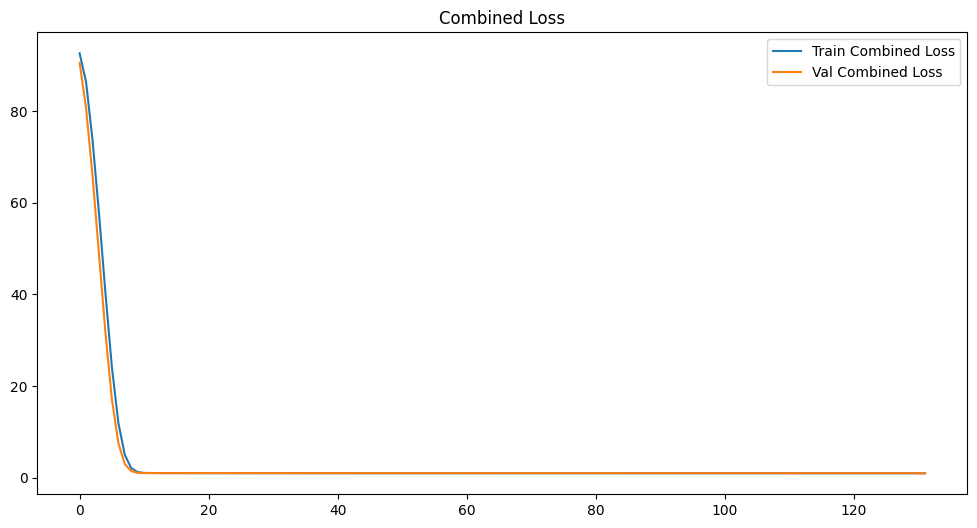

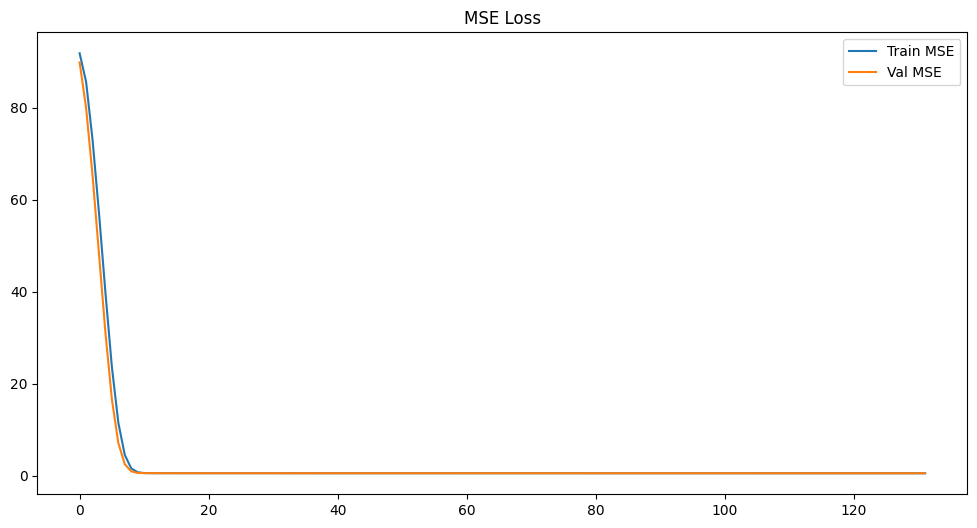

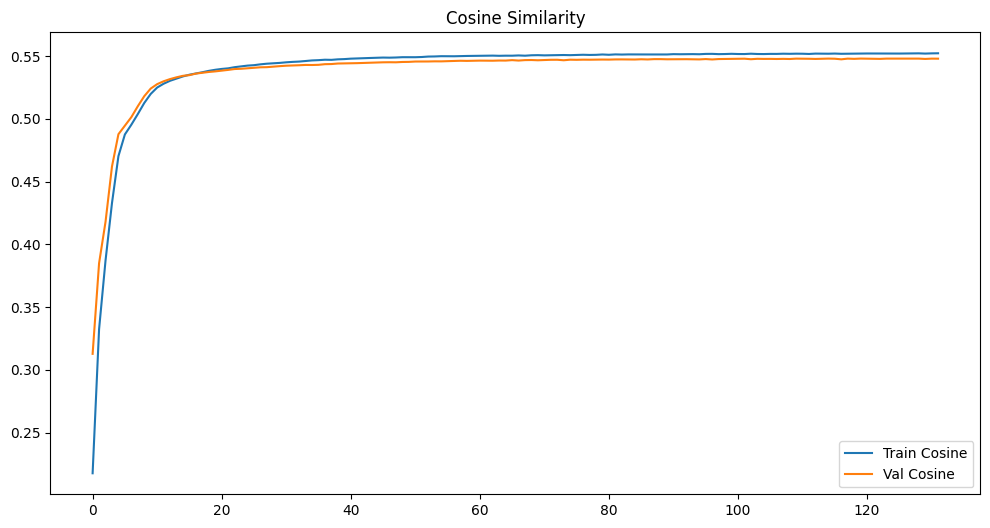

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)  # cosine per timestep

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics storage
train_combined_losses = []
train_mse_losses = []
train_cosine_avgs = []

val_combined_losses = []
val_mse_losses = []
val_cosine_avgs = []

best_val_loss = np.inf
patience = 5
patience_counter = 0

EPOCHS = 200

# ---------------- EVALUATION FUNCTION ---------------- #
def evaluate(model, loader):
    model.eval()
    total_combined = 0.0
    total_mse = 0.0
    total_cos = 0.0

    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

            out1, out2, out3 = model(Xb)

            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))

            cos1 = cosine_fn(out1, y1b).mean()
            cos2 = cosine_fn(out2, y2b).mean()
            cos3 = cosine_fn(out3, y3b).mean()

            avg_cos = (cos1 + cos2 + cos3) / 3.0
            combined_loss = mse + (1 - avg_cos)

            total_combined += combined_loss.item()
            total_mse += mse.item()
            total_cos += avg_cos.item()

    total_combined /= len(loader)
    total_mse /= len(loader)
    total_cos /= len(loader)

    return total_combined, total_mse, total_cos

# ---------------- TRAINING LOOP ---------------- #
for epoch in range(EPOCHS):
    model.train()

    epoch_combined = 0.0
    epoch_mse_val = 0.0
    epoch_cos_val = 0.0

    for Xb, y1b, y2b, y3b in loader:
        optimizer.zero_grad()

        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

        out1, out2, out3 = model(Xb)

        mse = (mse_loss(out1, y1b) +
               mse_loss(out2, y2b) +
               mse_loss(out3, y3b))

        cos1 = cosine_fn(out1, y1b).mean()
        cos2 = cosine_fn(out2, y2b).mean()
        cos3 = cosine_fn(out3, y3b).mean()

        avg_cos = (cos1 + cos2 + cos3) / 3.0

        combined_loss = mse + (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()

    # Training epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)

    train_combined_losses.append(epoch_combined)
    train_mse_losses.append(epoch_mse_val)
    train_cosine_avgs.append(epoch_cos_val)

    # ----- VALIDATION EVAL -----
    val_combined, val_mse, val_cos = evaluate(model, test_loader)

    val_combined_losses.append(val_combined)
    val_mse_losses.append(val_mse)
    val_cosine_avgs.append(val_cos)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Combined: {epoch_combined:.4f} | Val Combined: {val_combined:.4f} "
          f"| Train MSE: {epoch_mse_val:.4f} | Val MSE: {val_mse:.4f} "
          f"| Train Cos: {epoch_cos_val:.4f} | Val Cos: {val_cos:.4f}")

    # ---- EARLY STOPPING ---- #
    if val_combined < best_val_loss:
        best_val_loss = val_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_valid.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# =================== PLOTS =================== #
plt.figure(figsize=(12,6))
plt.plot(train_combined_losses, label="Train Combined Loss")
plt.plot(val_combined_losses, label="Val Combined Loss")
plt.legend()
plt.title("Combined Loss")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_mse_losses, label="Train MSE")
plt.plot(val_mse_losses, label="Val MSE")
plt.legend()
plt.title("MSE Loss")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_cosine_avgs, label="Train Cosine")
plt.plot(val_cosine_avgs, label="Val Cosine")
plt.legend()
plt.title("Cosine Similarity")
plt.show()


### Experiments 2

giving more weightage to cosine loss 

Epoch 1/200 | Stage: MSE + COS | Train Combined: 96.0457 | Val Combined: 93.8443 | Train MSE: 92.2179 | Val MSE: 90.5277 | Train Cos: 0.2344 | Val Cos: 0.3367
Model saved (new best).
Epoch 2/200 | Stage: MSE + COS | Train Combined: 90.0243 | Val Combined: 84.5115 | Train MSE: 86.7440 | Val MSE: 81.3941 | Train Cos: 0.3439 | Val Cos: 0.3765
Model saved (new best).
Epoch 3/200 | Stage: MSE + COS | Train Combined: 77.2975 | Val Combined: 69.0130 | Train MSE: 74.0777 | Val MSE: 65.8543 | Train Cos: 0.3560 | Val Cos: 0.3683
Model saved (new best).
Epoch 4/200 | Stage: MSE + COS | Train Combined: 60.3358 | Val Combined: 51.0754 | Train MSE: 57.2472 | Val MSE: 48.1666 | Train Cos: 0.3823 | Val Cos: 0.4182
Model saved (new best).
Epoch 5/200 | Stage: MSE + COS | Train Combined: 42.3784 | Val Combined: 33.5033 | Train MSE: 39.4401 | Val MSE: 30.6628 | Train Cos: 0.4123 | Val Cos: 0.4319
Model saved (new best).
Epoch 6/200 | Stage: MSE + COS | Train Combined: 26.0486 | Val Combined: 18.9906 | Tr

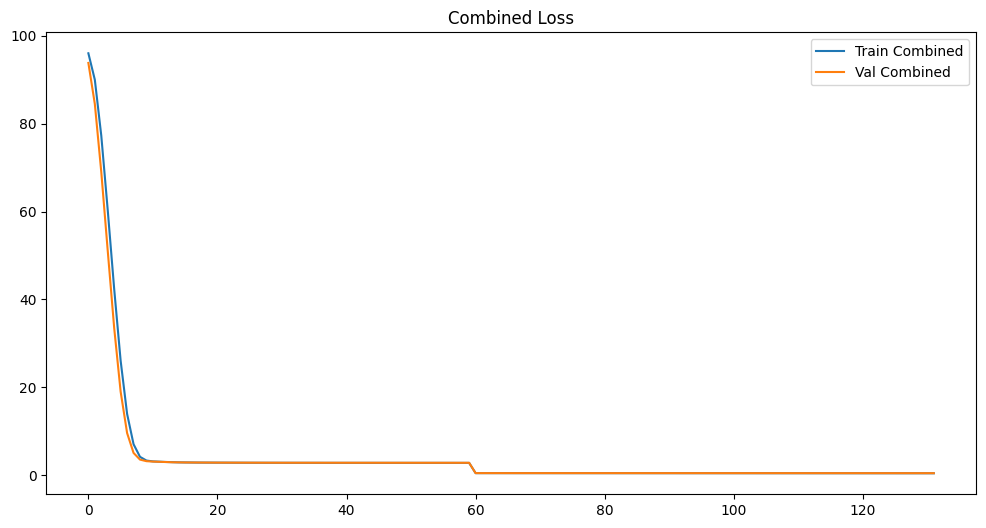

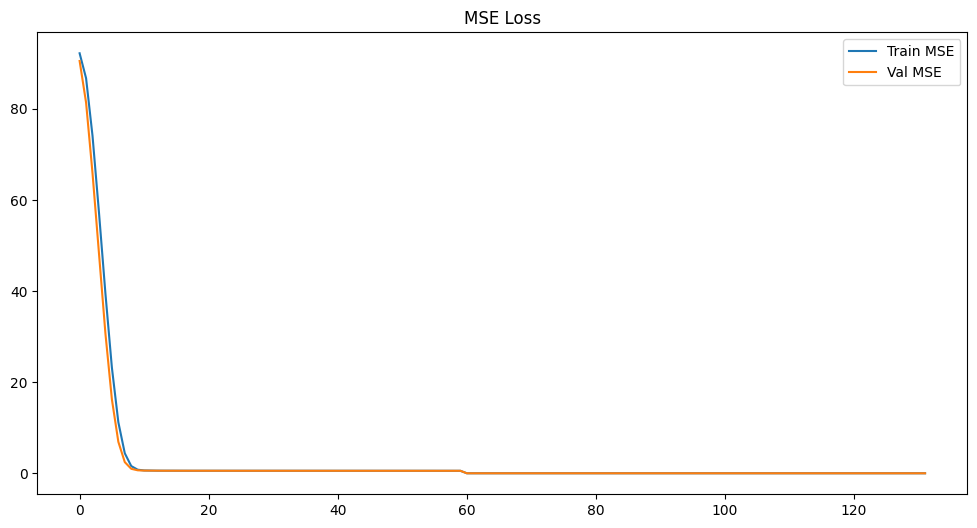

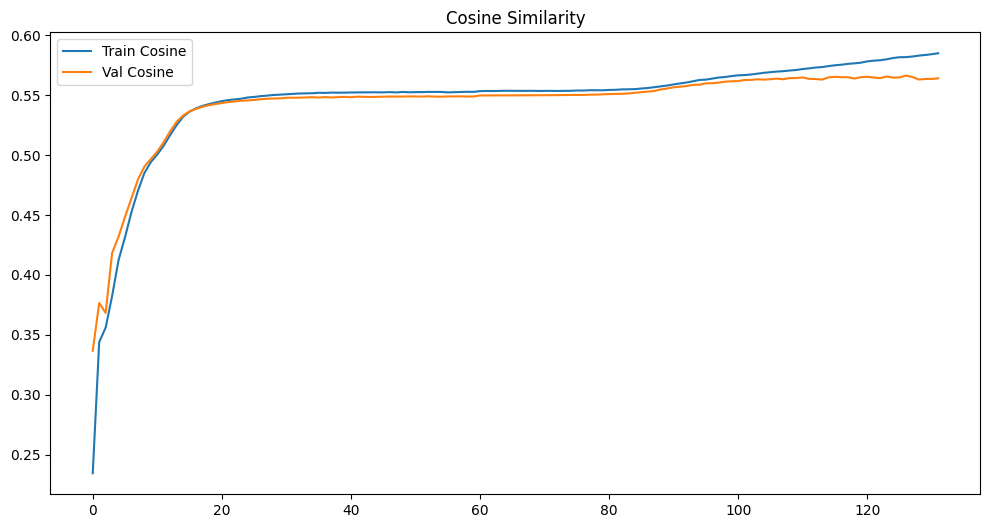

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Stage settings
STAGE1_EPOCHS = 60        # MSE + Cosine
STAGE2_EPOCHS = 140       # Cosine only
TOTAL_EPOCHS = STAGE1_EPOCHS + STAGE2_EPOCHS

alpha = 5                 # cosine loss weight in stage 1

# Metrics storage
train_combined_losses, train_mse_losses, train_cosine_avgs = [], [], []
val_combined_losses, val_mse_losses, val_cosine_avgs = [], [], []

best_val_loss = np.inf
patience = 5
patience_counter = 0

# ---------------- EVALUATION FUNCTION ---------------- #
def evaluate(model, loader, stage2=False):
    model.eval()
    total_combined, total_mse, total_cos = 0.0, 0.0, 0.0

    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()
            out1, out2, out3 = model(Xb)

            # cosine normalized values
            out1n = nn.functional.normalize(out1, dim=-1)
            out2n = nn.functional.normalize(out2, dim=-1)
            out3n = nn.functional.normalize(out3, dim=-1)
            y1n = nn.functional.normalize(y1b, dim=-1)
            y2n = nn.functional.normalize(y2b, dim=-1)
            y3n = nn.functional.normalize(y3b, dim=-1)

            cos1 = cosine_fn(out1n, y1n).mean()
            cos2 = cosine_fn(out2n, y2n).mean()
            cos3 = cosine_fn(out3n, y3n).mean()
            avg_cos = (cos1 + cos2 + cos3) / 3.0

            if stage2:
                combined_loss = (1 - avg_cos)
                mse = torch.tensor(0.0, device=Xb.device)
            else:
                mse = (mse_loss(out1, y1b) +
                       mse_loss(out2, y2b) +
                       mse_loss(out3, y3b))
                combined_loss = mse + alpha * (1 - avg_cos)

            total_combined += combined_loss.item()
            total_mse += mse.item()
            total_cos += avg_cos.item()

    return total_combined / len(loader), total_mse / len(loader), total_cos / len(loader)

# ---------------- TRAINING LOOP ---------------- #
for epoch in range(TOTAL_EPOCHS):
    stage2 = epoch >= STAGE1_EPOCHS  # switch point

    model.train()
    epoch_combined, epoch_mse_val, epoch_cos_val = 0.0, 0.0, 0.0

    for Xb, y1b, y2b, y3b in loader:
        optimizer.zero_grad()
        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()
        out1, out2, out3 = model(Xb)

        # cosine values
        out1n = nn.functional.normalize(out1, dim=-1)
        out2n = nn.functional.normalize(out2, dim=-1)
        out3n = nn.functional.normalize(out3, dim=-1)
        y1n = nn.functional.normalize(y1b, dim=-1)
        y2n = nn.functional.normalize(y2b, dim=-1)
        y3n = nn.functional.normalize(y3b, dim=-1)

        cos1 = cosine_fn(out1n, y1n).mean()
        cos2 = cosine_fn(out2n, y2n).mean()
        cos3 = cosine_fn(out3n, y3n).mean()
        avg_cos = (cos1 + cos2 + cos3) / 3.0

        if stage2:
            mse = torch.tensor(0.0, device=Xb.device)
            combined_loss = (1 - avg_cos)
        else:
            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))
            combined_loss = mse + alpha * (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()

    # epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)

    train_combined_losses.append(epoch_combined)
    train_mse_losses.append(epoch_mse_val)
    train_cosine_avgs.append(epoch_cos_val)

    # validation
    val_combined, val_mse, val_cos = evaluate(model, test_loader, stage2)
    val_combined_losses.append(val_combined)
    val_mse_losses.append(val_mse)
    val_cosine_avgs.append(val_cos)

    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} | Stage: {'COSINE ONLY' if stage2 else 'MSE + COS'} "
          f"| Train Combined: {epoch_combined:.4f} | Val Combined: {val_combined:.4f} "
          f"| Train MSE: {epoch_mse_val:.4f} | Val MSE: {val_mse:.4f} "
          f"| Train Cos: {epoch_cos_val:.4f} | Val Cos: {val_cos:.4f}")

    # ---- EARLY STOPPING ---- #
    if val_combined < best_val_loss:
        best_val_loss = val_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_two_stage.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# =================== PLOTS =================== #
plt.figure(figsize=(12,6))
plt.plot(train_combined_losses, label="Train Combined")
plt.plot(val_combined_losses, label="Val Combined")
plt.legend(); plt.title("Combined Loss"); plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_mse_losses, label="Train MSE")
plt.plot(val_mse_losses, label="Val MSE")
plt.legend(); plt.title("MSE Loss"); plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_cosine_avgs, label="Train Cosine")
plt.plot(val_cosine_avgs, label="Val Cosine")
plt.legend(); plt.title("Cosine Similarity"); plt.show()


### Experiment 3

KeyboardInterrupt: 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
y1_train = torch.tensor(y1_train, dtype=torch.float32).cuda()
y2_train = torch.tensor(y2_train, dtype=torch.float32).cuda()
y3_train = torch.tensor(y3_train, dtype=torch.float32).cuda()


In [9]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, y1_train, y2_train, y3_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiOutputTransformer(nn.Module):
    def __init__(self, input_dim=128, d_model=512, nhead=8, num_layers=4, ff_dim=1024):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, ff_dim, batch_first=True),
            num_layers=num_layers
        )

        self.query_tokens = nn.Parameter(torch.randn(20, d_model))
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, ff_dim, batch_first=True),
            num_layers=2
        )

        # projection heads
        self.head1 = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))
        self.head2 = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))
        self.head3 = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Linear(d_model, d_model))

        self.out1 = nn.Linear(d_model, 768)
        self.out2 = nn.Linear(d_model, 1280)
        self.out3 = nn.Linear(d_model, 4096)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoding(x)
        x = self.encoder(x)

        q = self.query_tokens.unsqueeze(0).repeat(x.size(0), 1, 1)
        x = self.decoder(q, x)

        y1 = F.normalize(self.out1(self.head1(x)), dim=-1)
        y2 = F.normalize(self.out2(self.head2(x)), dim=-1)
        y3 = F.normalize(self.out3(self.head3(x)), dim=-1)

        return y1, y2, y3


Epoch 1/200 | Train Combined: 95.3099 | Val Combined: 95.0889 | Train MSE: 92.9564 | Val MSE: 92.9371 | Train Avg Cos: 0.5293 | Val Avg Cos: 0.5696
Model saved (new best).
Epoch 2/200 | Train Combined: 95.0464 | Val Combined: 95.0429 | Train MSE: 92.9395 | Val MSE: 92.9360 | Train Avg Cos: 0.5786 | Val Avg Cos: 0.5786
Model saved (new best).
Epoch 3/200 | Train Combined: 95.0101 | Val Combined: 95.0175 | Train MSE: 92.9383 | Val MSE: 92.9354 | Train Avg Cos: 0.5856 | Val Avg Cos: 0.5836
Model saved (new best).
Epoch 4/200 | Train Combined: 94.9872 | Val Combined: 95.0026 | Train MSE: 92.9379 | Val MSE: 92.9351 | Train Avg Cos: 0.5901 | Val Avg Cos: 0.5865
Model saved (new best).
Epoch 5/200 | Train Combined: 94.9703 | Val Combined: 94.9988 | Train MSE: 92.9375 | Val MSE: 92.9350 | Train Avg Cos: 0.5934 | Val Avg Cos: 0.5872
Model saved (new best).
Epoch 6/200 | Train Combined: 94.9552 | Val Combined: 94.9858 | Train MSE: 92.9372 | Val MSE: 92.9347 | Train Avg Cos: 0.5964 | Val Avg Cos:

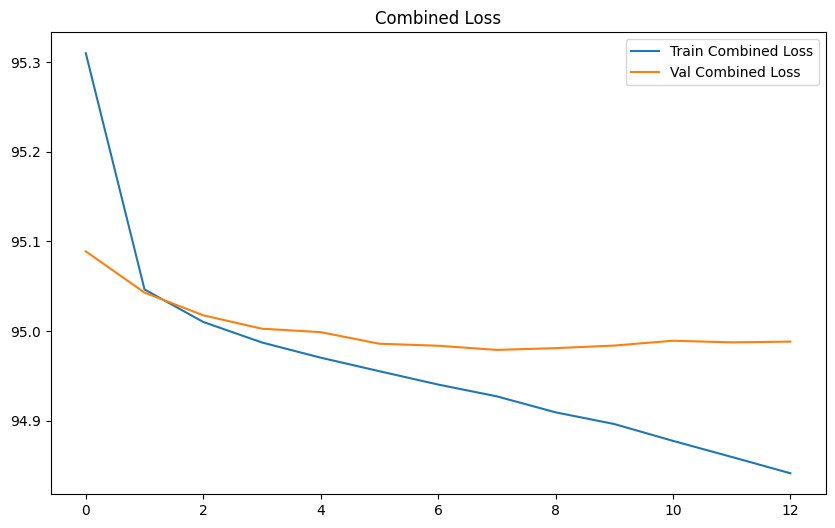

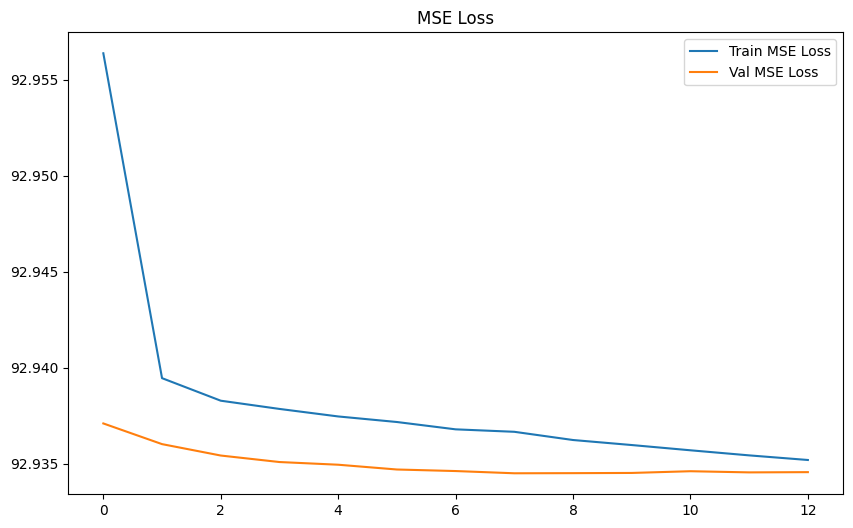

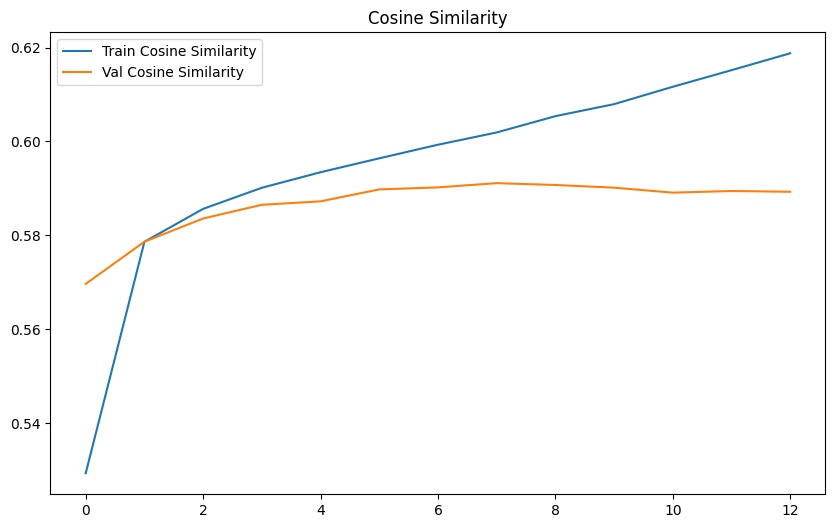

In [17]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)  # cosine per timestep

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics storage
combined_losses = []
mse_losses = []
cosine_avgs = []
cosine1 = []
cosine2 = []
cosine3 = []

val_combined_losses = []
val_mse_losses = []
val_cosine_avgs = []

best_val_loss = np.inf
patience = 5
patience_counter = 0

EPOCHS = 200

# ================= VALIDATION FUNCTION ================= #
def validate(model, loader):
    model.eval()
    total_combined = 0.0
    total_mse = 0.0
    total_cos = 0.0
    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

            out1, out2, out3 = model(Xb)

            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))

            cos1 = cosine_fn(out1, y1b).mean()
            cos2 = cosine_fn(out2, y2b).mean()
            cos3 = cosine_fn(out3, y3b).mean()
            avg_cos = (cos1 + cos2 + cos3) / 3.0

            combined_loss = mse + 5 * (1 - avg_cos)

            total_combined += combined_loss.item()
            total_mse += mse.item()
            total_cos += avg_cos.item()

    total_combined /= len(loader)
    total_mse /= len(loader)
    total_cos /= len(loader)
    return total_combined, total_mse, total_cos


# ================= TRAINING LOOP ================= #
for epoch in range(EPOCHS):
    model.train()

    epoch_combined = 0.0
    epoch_mse_val = 0.0
    epoch_cos_val = 0.0
    epoch_cos_1 = 0.0
    epoch_cos_2 = 0.0
    epoch_cos_3 = 0.0

    for batch_idx, (Xb, y1b, y2b, y3b) in enumerate(loader):

        optimizer.zero_grad()
        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

        out1, out2, out3 = model(Xb)

        mse = (mse_loss(out1, y1b) +
               mse_loss(out2, y2b) +
               mse_loss(out3, y3b))

        cos1 = cosine_fn(out1, y1b).mean()
        cos2 = cosine_fn(out2, y2b).mean()
        cos3 = cosine_fn(out3, y3b).mean()

        avg_cos = (cos1 + cos2 + cos3) / 3.0
        combined_loss = mse + 5 * (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()
        epoch_cos_1 += cos1
        epoch_cos_2 += cos2
        epoch_cos_3 += cos3

    # Train epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)
    epoch_cos_1 /= len(loader)
    epoch_cos_2 /= len(loader)
    epoch_cos_3 /= len(loader)

    combined_losses.append(epoch_combined)
    mse_losses.append(epoch_mse_val)
    cosine_avgs.append(epoch_cos_val)
    cosine1.append(epoch_cos_1)
    cosine2.append(epoch_cos_2)
    cosine3.append(epoch_cos_3)

    # ================= VALIDATION ================= #
    val_combined, val_mse, val_cos = validate(model, test_loader)
    val_combined_losses.append(val_combined)
    val_mse_losses.append(val_mse)
    val_cosine_avgs.append(val_cos)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Combined: {epoch_combined:.4f} "
          f"| Val Combined: {val_combined:.4f} "
          f"| Train MSE: {epoch_mse_val:.4f} "
          f"| Val MSE: {val_mse:.4f} "
          f"| Train Avg Cos: {epoch_cos_val:.4f} "
          f"| Val Avg Cos: {val_cos:.4f}")

    # === Early Stopping on validation combined loss ===
    if val_combined < best_val_loss:
        best_val_loss = val_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# === Plot metrics ===
plt.figure(figsize=(10,6))
plt.plot(combined_losses, label="Train Combined Loss")
plt.plot(val_combined_losses, label="Val Combined Loss")
plt.legend()
plt.title("Combined Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(mse_losses, label="Train MSE Loss")
plt.plot(val_mse_losses, label="Val MSE Loss")
plt.legend()
plt.title("MSE Loss")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(cosine_avgs, label="Train Cosine Similarity")
plt.plot(val_cosine_avgs, label="Val Cosine Similarity")
plt.legend()
plt.title("Cosine Similarity")
plt.show()


Epoch 1/200 | Combined Loss: 95.3064 | MSE: 92.9555 | Avg Cos: 0.5298| Cos 1 : 0.525394856929779|Cos 2 : 0.5251001715660095|Cos 3 : 0.5389605760574341
Model saved (new best).
Epoch 2/200 | Combined Loss: 95.0496 | MSE: 92.9394 | Avg Cos: 0.5780| Cos 1 : 0.5776111483573914|Cos 2 : 0.5716444253921509|Cos 3 : 0.584612250328064
Model saved (new best).
Epoch 3/200 | Combined Loss: 95.0117 | MSE: 92.9385 | Avg Cos: 0.5853| Cos 1 : 0.5902501940727234|Cos 2 : 0.5764589905738831|Cos 3 : 0.5893233418464661
Model saved (new best).
Epoch 4/200 | Combined Loss: 94.9868 | MSE: 92.9379 | Avg Cos: 0.5902| Cos 1 : 0.5986244082450867|Cos 2 : 0.5797690749168396|Cos 3 : 0.5922697186470032
Model saved (new best).
Epoch 5/200 | Combined Loss: 94.9696 | MSE: 92.9375 | Avg Cos: 0.5936| Cos 1 : 0.6041266322135925|Cos 2 : 0.5820908546447754|Cos 3 : 0.5945313572883606
Model saved (new best).
Epoch 6/200 | Combined Loss: 94.9545 | MSE: 92.9371 | Avg Cos: 0.5965| Cos 1 : 0.6088832020759583|Cos 2 : 0.58407104015350

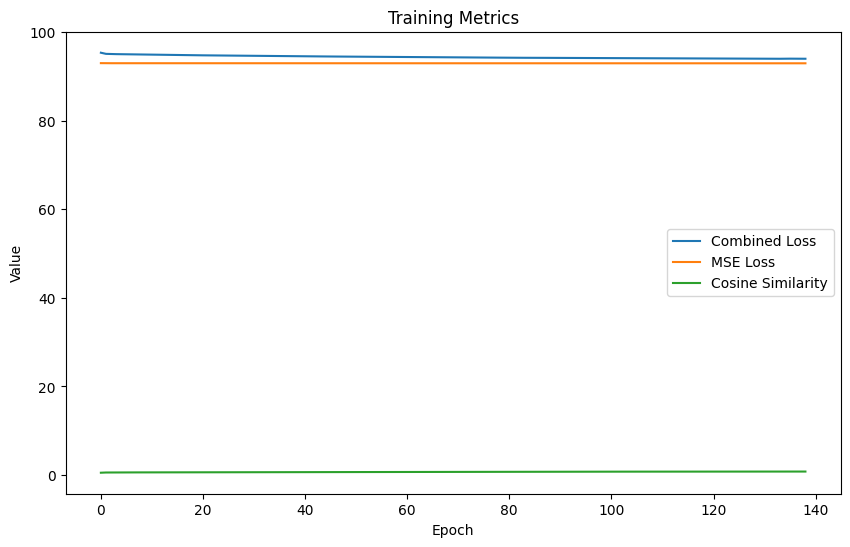

In [11]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define loss functions
mse_loss = nn.MSELoss()
cosine_fn = nn.CosineSimilarity(dim=-1)  # cosine per timestep

model = MultiOutputTransformer().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metrics storage
combined_losses = []
mse_losses = []
cosine_avgs = []
cosine1 = []
cosine2 = []
cosine3 = []
best_val_loss = np.inf
patience = 5
patience_counter = 0

EPOCHS = 200

for epoch in range(EPOCHS):
    model.train()

    epoch_combined = 0.0
    epoch_mse_val = 0.0
    epoch_cos_val = 0.0
    epoch_cos_1 = 0.0
    epoch_cos_2 = 0.0
    epoch_cos_3 = 0.0
    for batch_idx, (Xb, y1b, y2b, y3b) in enumerate(loader):

        optimizer.zero_grad()

        Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

        out1, out2, out3 = model(Xb)

        # ===== MSE loss =====
        mse = (mse_loss(out1, y1b) +
               mse_loss(out2, y2b) +
               mse_loss(out3, y3b))

        # ===== Cosine similarity =====
        cos1 = cosine_fn(out1, y1b).mean()
        cos2 = cosine_fn(out2, y2b).mean()
        cos3 = cosine_fn(out3, y3b).mean()

        avg_cos = (cos1 + cos2 + cos3) / 3.0   # stays in [-1,1]

        # ===== Combined Loss =====
        combined_loss = mse + 5 * (1 - avg_cos)

        combined_loss.backward()
        optimizer.step()

        epoch_combined += combined_loss.item()
        epoch_mse_val += mse.item()
        epoch_cos_val += avg_cos.item()
        epoch_cos_1 += cos1 
        epoch_cos_2 += cos2
        epoch_cos_3 += cos3 
    # Epoch averages
    epoch_combined /= len(loader)
    epoch_mse_val /= len(loader)
    epoch_cos_val /= len(loader)
    epoch_cos_1 /= len(loader)
    epoch_cos_2 /= len(loader)
    epoch_cos_3 /= len(loader)

    combined_losses.append(epoch_combined)
    mse_losses.append(epoch_mse_val)
    cosine_avgs.append(epoch_cos_val)
    cosine1.append(epoch_cos_1)
    cosine2.append(epoch_cos_2)
    cosine3.append(epoch_cos_3)
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Combined Loss: {epoch_combined:.4f} "
          f"| MSE: {epoch_mse_val:.4f} "
          f"| Avg Cos: {epoch_cos_val:.4f}" 
          f"| Cos 1 : {epoch_cos_1}"
          f"|Cos 2 : {epoch_cos_2}"
          f"|Cos 3 : {epoch_cos_3}")

    # === Early Stopping ===
    if epoch_combined < best_val_loss:
        best_val_loss = epoch_combined
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved (new best).")
    else:
        patience_counter += 1
        print(f"No improvement. Patience {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# === Plot metrics ===
plt.figure(figsize=(10,6))
plt.plot(combined_losses, label="Combined Loss")
plt.plot(mse_losses, label="MSE Loss")
plt.plot(cosine_avgs, label="Cosine Similarity")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Metrics")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Training Metrics')

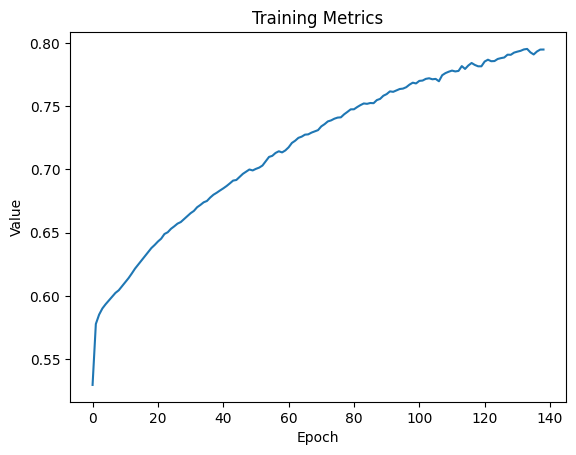

In [12]:
plt.plot(cosine_avgs, label="Cosine Similarity")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Metrics")

In [13]:
from torch.utils.data import TensorDataset, DataLoader

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y1_test_t = torch.tensor(y1_test, dtype=torch.float32)
y2_test_t = torch.tensor(y2_test, dtype=torch.float32)
y3_test_t = torch.tensor(y3_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_t, y1_test_t, y2_test_t, y3_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
def evaluate(model, loader):
    model.eval()
    test_combined = 0.0
    test_mse_val = 0.0
    test_cos_val = 0.0

    with torch.no_grad():
        for Xb, y1b, y2b, y3b in loader:
            Xb, y1b, y2b, y3b = Xb.cuda(), y1b.cuda(), y2b.cuda(), y3b.cuda()

            out1, out2, out3 = model(Xb)

            # --- MSE ---
            mse = (mse_loss(out1, y1b) +
                   mse_loss(out2, y2b) +
                   mse_loss(out3, y3b))

            # --- Cosine Similarity ---
            cos1 = cosine_fn(out1, y1b).mean()
            cos2 = cosine_fn(out2, y2b).mean()
            cos3 = cosine_fn(out3, y3b).mean()

            avg_cos = (cos1 + cos2 + cos3) / 3.0

            # --- Combined Loss ---
            combined_loss = mse + (1 - avg_cos)

            test_combined += combined_loss.item()
            test_mse_val += mse.item()
            test_cos_val += avg_cos.item()

    test_combined /= len(loader)
    test_mse_val /= len(loader)
    test_cos_val /= len(loader)

    return test_combined, test_mse_val, test_cos_val


In [15]:
model.load_state_dict(torch.load("best_model.pt"))  # best saved model
test_combined, test_mse, test_cos = evaluate(model, test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Combined Loss: {test_combined:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Avg Cosine Similarity: {test_cos:.4f}")
print("========================")



===== TEST RESULTS =====
Test Combined Loss: 93.4085
Test MSE: 92.9389
Test Avg Cosine Similarity: 0.5303


### Experiment 4

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import math


# ============================================================
# 1. Loss functions
# ============================================================

def sequence_mse_loss(pred, target):
    """
    pred, target: [B, T, D]
    Simple MSE over all elements.
    """
    return F.mse_loss(pred, target)


def sequence_cosine_loss(pred, target, eps=1e-8):
    """
    1 - cosine similarity averaged over (B, T).
    """
    # [B, T, D] -> normalize along D
    pred_norm = F.normalize(pred, dim=-1, eps=eps)
    target_norm = F.normalize(target, dim=-1, eps=eps)

    # cosine per token: [B, T]
    cos_sim = (pred_norm * target_norm).sum(dim=-1)

    # loss = 1 - mean cosine similarity
    return 1.0 - cos_sim.mean()


class MultiHeadDistillationLoss(nn.Module):
    """
    Combines losses for the 3 heads (y1, y2, y3).
    Each head uses MSE + cosine.
    """

    def __init__(self,
                 w1=1.0,
                 w2=1.0,
                 w3=1.0,
                 alpha_mse=1.0,
                 beta_cos=1.0):
        super().__init__()
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.alpha_mse = alpha_mse
        self.beta_cos = beta_cos

    def head_loss(self, pred, target):
        mse = sequence_mse_loss(pred, target)
        cos = sequence_cosine_loss(pred, target)
        return self.alpha_mse * mse + self.beta_cos * cos, mse, cos

    def forward(self,
                pred1, tgt1,
                pred2, tgt2,
                pred3, tgt3):

        loss1, mse1, cos1 = self.head_loss(pred1, tgt1)
        loss2, mse2, cos2 = self.head_loss(pred2, tgt2)
        loss3, mse3, cos3 = self.head_loss(pred3, tgt3)

        total = (self.w1 * loss1 +
                 self.w2 * loss2 +
                 self.w3 * loss3)

        logs = {
            "loss_total": total.item(),
            "loss_y1": loss1.item(),
            "loss_y2": loss2.item(),
            "loss_y3": loss3.item(),
            "mse_y1": mse1.item(),
            "mse_y2": mse2.item(),
            "mse_y3": mse3.item(),
            "cos_y1": cos1.item(),
            "cos_y2": cos2.item(),
            "cos_y3": cos3.item(),
        }
        return total, logs


# ============================================================
# 2. Model: Audio encoder + query-based decoders
# ============================================================

class AudioEncoder(nn.Module):
    """
    Transformer encoder operating on VGGish embeddings.
    Input:  [B, 10, 128]
    Output: [B, 10, d_model]
    """

    def __init__(self,
                 d_audio=128,
                 d_model=512,
                 num_layers=4,
                 num_heads=8,
                 dropout=0.1):
        super().__init__()

        self.proj = nn.Linear(d_audio, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer,
                                             num_layers=num_layers)

    def forward(self, x, src_key_padding_mask):
        # x: [B, 10, 128]
        x = self.proj(x)  # -> [B, 10, d_model]
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        return x          # -> [B, 10, d_model]


class TextEmbeddingDecoder(nn.Module):
    """
    Uses learned queries + cross-attention to map audio → text-encoder embeddings.

    num_tokens: 20 (from your y1, y2, y3 shapes)
    """
    def __init__(self,
                 num_tokens=20,
                 d_model=512,
                 output_dim=768,
                 num_layers=4,
                 num_heads=8,
                 dropout=0.1):
        super().__init__()

        # Learned query embeddings (acts like pseudo-text tokens)
        self.query_tokens = nn.Parameter(torch.randn(num_tokens, d_model))

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer,
                                             num_layers=num_layers)

        # Final linear projection to match diffusion model text encoder dims
        self.out_proj = nn.Linear(d_model, output_dim)

    def forward(self, memory, memory_key_padding_mask):
        """
        memory: [B, 10, d_model] - encoded audio sequence
        """
        B = memory.shape[0]

        # Expand learned query tokens for the batch
        query = self.query_tokens.unsqueeze(0).expand(B, -1, -1)  # [B, 20, d_model]

        # Cross-attention: queries attend to audio memory
        decoded = self.decoder(
            tgt=query,
            memory=memory,
            memory_key_padding_mask=memory_key_padding_mask
        )  # -> [B, 20, d_model]

        # Project to actual text encoder embedding dimensions
        return self.out_proj(decoded)  # [B, 20, output_dim]


class AudioToTextEmbeddings(nn.Module):
    """
    Full model:
    - Shared audio encoder
    - 3 decoder heads producing y1, y2, y3
    """

    def __init__(self,
                 d_audio=128,
                 d_model=512,
                 num_tokens=20):
        super().__init__()

        self.d_model = d_model

        # Shared audio transformer encoder
        self.audio_encoder = AudioEncoder(d_audio=d_audio,
                                          d_model=d_model)

        # Decoder heads for your 3 text encoders
        self.head_y1 = TextEmbeddingDecoder(num_tokens=num_tokens,
                                            d_model=d_model,
                                            output_dim=768)
        self.head_y2 = TextEmbeddingDecoder(num_tokens=num_tokens,
                                            d_model=d_model,
                                            output_dim=1280)
        self.head_y3 = TextEmbeddingDecoder(num_tokens=num_tokens,
                                            d_model=d_model,
                                            output_dim=4096)

    def forward(self, audio_seq, audio_mask):
        """
        audio_seq: [B, 10, 128]
        audio_mask: [B, 10] — True where padded values are located
        (if everything is real data, this can be all False)
        """
        H = self.audio_encoder(audio_seq, audio_mask)  # [B, 10, d_model]

        out1 = self.head_y1(H, audio_mask)  # [B, 20, 768]
        out2 = self.head_y2(H, audio_mask)  # [B, 20, 1280]
        out3 = self.head_y3(H, audio_mask)  # [B, 20, 4096]

        return out1, out2, out3


# ============================================================
# 3. Dataset & DataLoader
# ============================================================

class AudioTextEmbDataset(Dataset):
    """
    Simple dataset for:
      X  : [N, 10, 128]
      y1 : [N, 20, 768]
      y2 : [N, 20, 1280]
      y3 : [N, 20, 4096]
    """

    def __init__(self, X, y1, y2, y3):
        """
        X, y1, y2, y3 can be numpy arrays or torch tensors.
        """
        # Convert to torch if needed
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y1):
            y1 = torch.from_numpy(y1).float()
        if not torch.is_tensor(y2):
            y2 = torch.from_numpy(y2).float()
        if not torch.is_tensor(y3):
            y3 = torch.from_numpy(y3).float()

        assert X.ndim == 3 and X.shape[1:] == (10, 128), f"X shape must be (N,10,128), got {X.shape}"
        assert y1.ndim == 3 and y1.shape[1:] == (20, 768)
        assert y2.ndim == 3 and y2.shape[1:] == (20, 1280)
        assert y3.ndim == 3 and y3.shape[1:] == (20, 4096)
        assert X.shape[0] == y1.shape[0] == y2.shape[0] == y3.shape[0]

        self.X = X
        self.y1 = y1
        self.y2 = y2
        self.y3 = y3

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        audio_seq = self.X[idx]   # [10, 128]
        t1 = self.y1[idx]         # [20, 768]
        t2 = self.y2[idx]         # [20, 1280]
        t3 = self.y3[idx]         # [20, 4096]

        return {
            "audio_seq": audio_seq,
            "target_1": t1,
            "target_2": t2,
            "target_3": t3,
        }


def collate_fn(batch):
    """
    Since all sequences are fixed-length (10, 20), we just stack.
    If you know exact valid length per sample, you can build a real mask here.
    """
    audio_seq = torch.stack([b["audio_seq"] for b in batch], dim=0)  # [B, 10, 128]

    # No actual padding in this simple setup; everything is "real"
    B, T, _ = audio_seq.shape
    audio_mask = torch.zeros(B, T, dtype=torch.bool)  # False = not padding

    tgt1 = torch.stack([b["target_1"] for b in batch], dim=0)        # [B, 20, 768]
    tgt2 = torch.stack([b["target_2"] for b in batch], dim=0)        # [B, 20, 1280]
    tgt3 = torch.stack([b["target_3"] for b in batch], dim=0)        # [B, 20, 4096]

    return {
        "audio_seq": audio_seq,
        "audio_mask": audio_mask,
        "target_1": tgt1,
        "target_2": tgt2,
        "target_3": tgt3,
    }


# ============================================================
# 4. Training & Validation
# ============================================================

@torch.no_grad()
def validate(model, val_loader, loss_fn, device="cuda"):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    for batch in val_loader:
        audio_seq = batch["audio_seq"].to(device)      # [B, 10, 128]
        audio_mask = batch["audio_mask"].to(device)    # [B, 10]
        tgt1 = batch["target_1"].to(device)            # [B, 20, 768]
        tgt2 = batch["target_2"].to(device)            # [B, 20, 1280]
        tgt3 = batch["target_3"].to(device)            # [B, 20, 4096]

        pred1, pred2, pred3 = model(audio_seq, audio_mask)

        loss, logs = loss_fn(pred1, tgt1, pred2, tgt2, pred3, tgt3)
        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(1, n_batches)
    print(f"[VAL] Avg loss: {avg_loss:.4f}")
    return avg_loss


def train_model(
    model,
    train_dataset,
    val_dataset=None,
    epochs=10,
    batch_size=8,
    lr=1e-4,
    device=None,
    log_every=10,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True,
    )

    if val_dataset is not None:
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=4,
            pin_memory=True,
        )
    else:
        val_loader = None

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = MultiHeadDistillationLoss(
        w1=1.0, w2=1.0, w3=1.0,
        alpha_mse=1.0, beta_cos=1.0
    )

    global_step = 0
    for epoch in range(epochs):
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            audio_seq = batch["audio_seq"].to(device)
            audio_mask = batch["audio_mask"].to(device)
            tgt1 = batch["target_1"].to(device)
            tgt2 = batch["target_2"].to(device)
            tgt3 = batch["target_3"].to(device)

            optimizer.zero_grad(set_to_none=True)

            pred1, pred2, pred3 = model(audio_seq, audio_mask)

            loss, logs = loss_fn(pred1, tgt1, pred2, tgt2, pred3, tgt3)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if global_step % log_every == 0:


                print(
                    f"Epoch {epoch} Step {global_step} "
                    f"Total:{logs['loss_total']:.3f} | "
                    f"MSE:[{logs['mse_y1']:.3f}, {logs['mse_y2']:.3f}, {logs['mse_y3']:.3f}] | "
                    f"COS:[{logs['cos_y1']:.3f}, {logs['cos_y2']:.3f}, {logs['cos_y3']:.3f}]"
                )

            global_step += 1

        # end of epoch: validation
        if val_loader is not None:
            validate(model, val_loader, loss_fn, device=device)

    return model


# ============================================================
# 5. Convenience function to train from your arrays
# ============================================================

def train_from_arrays(
    X, y1, y2, y3,
    val_split=0.1,
    epochs=10,
    batch_size=8,
    lr=1e-4,
):
    """
    X  : (N, 10, 128)
    y1 : (N, 20, 768)
    y2 : (N, 20, 1280)
    y3 : (N, 20, 4096)
    val_split: fraction of data for validation.
    """
    N = X.shape[0]
    idx = torch.randperm(N)
    n_val = int(N * val_split)
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    # Split arrays
    X_train, X_val = X[train_idx], X[val_idx]
    y1_train, y1_val = y1[train_idx], y1[val_idx]
    y2_train, y2_val = y2[train_idx], y2[val_idx]
    y3_train, y3_val = y3[train_idx], y3[val_idx]

    train_ds = AudioTextEmbDataset(X_train, y1_train, y2_train, y3_train)
    val_ds = AudioTextEmbDataset(X_val, y1_val, y2_val, y3_val)

    model = AudioToTextEmbeddings(d_audio=128, d_model=512, num_tokens=20)
    model = train_model(
        model,
        train_ds,
        val_dataset=val_ds,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
    )
    return model


# ============================================================
# 6. Example usage
# ============================================================
if __name__ == "__main__":
    """
    Example:
      Replace the random tensors with your real data loaded from disk.
      E.g., X = np.load("X.npy"), etc.
    """
    import numpy as np
    model = train_from_arrays(
        X, y1, y2, y3,
        val_split=0.1,   # 9000 train, 1000 val
        epochs=20,
        batch_size=32,
        lr= 1e-4,
    )

    print("Training finished.")


Epoch 0 Step 0 Total:97.135 | MSE:[92.954, 0.855, 0.351] | COS:[0.984, 0.991, 1.001]
Epoch 0 Step 10 Total:93.691 | MSE:[90.878, 0.532, 0.125] | COS:[0.779, 0.672, 0.705]
Epoch 0 Step 20 Total:92.754 | MSE:[90.517, 0.472, 0.064] | COS:[0.586, 0.578, 0.537]
Epoch 0 Step 30 Total:92.399 | MSE:[90.298, 0.445, 0.048] | COS:[0.536, 0.555, 0.517]
Epoch 0 Step 40 Total:92.107 | MSE:[90.131, 0.419, 0.041] | COS:[0.510, 0.509, 0.496]
Epoch 0 Step 50 Total:91.968 | MSE:[89.994, 0.406, 0.040] | COS:[0.535, 0.490, 0.503]
Epoch 0 Step 60 Total:91.769 | MSE:[89.838, 0.392, 0.040] | COS:[0.531, 0.477, 0.491]
Epoch 0 Step 70 Total:91.566 | MSE:[89.675, 0.377, 0.038] | COS:[0.515, 0.466, 0.494]
Epoch 0 Step 80 Total:91.336 | MSE:[89.525, 0.362, 0.035] | COS:[0.500, 0.451, 0.463]
Epoch 0 Step 90 Total:91.368 | MSE:[89.390, 0.384, 0.038] | COS:[0.555, 0.499, 0.502]
Epoch 0 Step 100 Total:90.965 | MSE:[89.228, 0.356, 0.033] | COS:[0.476, 0.433, 0.439]
Epoch 0 Step 110 Total:90.957 | MSE:[89.085, 0.373, 0.

In [33]:
torch.save(model.state_dict(), "experiment4.pth")


In [36]:
model = AudioToTextEmbeddings(d_audio=128, d_model=512, num_tokens=20)
model.load_state_dict(torch.load("experiment4.pth", map_location="cuda"))
model.cuda()
model.eval()
audio_seq = torch.randn(1, 10, 128).cuda()   # [B=1,10,128]
audio_mask = torch.zeros(1, 10, dtype=torch.bool).cuda()

with torch.no_grad():
    y1, y2, y3 = model(audio_seq, audio_mask)

print(y1.shape, y2.shape, y3.shape) 

torch.Size([1, 20, 768]) torch.Size([1, 20, 1280]) torch.Size([1, 20, 4096])
